In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import galois
import sha3
from Crypto.Hash import keccak
from fastecdsa.curve import Curve
from fastecdsa.point import Point
from fastecdsa.curve import secp256k1

In [7]:
nir = np.load("../../data/nir.npy").astype("int")
swir = np.load("../../data/swir.npy").astype("int")
nir = nir - nir.min()
swir = swir - swir.min()
nir.shape

(247, 211)

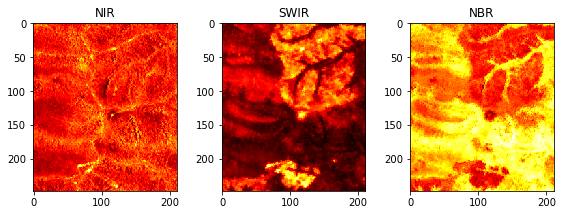

In [8]:
fig, ax = plt.subplots(1,3, figsize=(8, 8))
fig.tight_layout()
ax[0].imshow(nir, cmap='hot', interpolation='nearest')
ax[1].imshow(swir, cmap='hot', interpolation='nearest')
ax[2].imshow((nir-swir)/(nir+swir), cmap='hot', interpolation='nearest')
ax[0].set_title('NIR')
ax[1].set_title('SWIR')
ax[2].set_title('NBR')
plt.show()

In [387]:
sample_f = nir[50,:2]
sample_l = swir[50,:2]

sample_f.shape

a0 = nir[50,:2]
b0 = swir[50,:2]
a1 = nir[100,:2]
b1 = swir[100,:2]

In [13]:
# GF_BN254 = galois.GF(21888242871839275222246405745257275088548364400416034343698204186575808495616)
# srsD = 20
# alphaRaw = GF_BN254(4537460542209314651160888417413866091249215769242027952878258319870902529429)
# xRaw = GF_BN254(4518563069472097478295524977775021906947577384653869551543466909390271555451)
# ECDSA signature following tutorial from https://levelup.gitconnected.com/ecdsa-how-to-programmatically-sign-a-transaction-95eec854bca7
Pcurve = 2**256-2**32-2**9-2**8-2**7-2**6-2**4-1
N = 0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEBAAEDCE6AF48A03BBFD25E8CD0364141
Ac = 0
Bc = 7
Gx = 0x79BE667EF9DCBBAC55A06295CE870B07029BFCDB2DCE28D959F2815B16F81798
Gy = 0x483ADA7726A3C4655DA4FBFC0E1108A8FD17B448A68554199C47D08FFB10D4B8
def egcd(a, b):
     if a == 0:
          return (b, 0, 1)
     else:
          g, y, x = egcd(b % a, a)
          return (g, x - (b // a) * y, y)
          
def modinv(a, m):
    g, x, y = egcd(a, m)
    if g != 1:
        raise Exemption('modular inverse does not exist')
    else:
        return x % m

In [14]:

pair = None
with open("../../output/proof.txt") as f:
    proof = f.read()
    substr = proof.split("prRRaw = A (P ")[1].split("), prT = A (P ")[0]
    pair = substr.split(") (P ")
    # pair = proof[193: 269] + proof[274: 351]
print(pair)
k = '0x' + keccak.new(data=(pair[0]+pair[1]).encode(), digest_bits=256).hexdigest()
print(k)
GenPoint = Point(Gx, Gy, curve=secp256k1)

['2154372246320799745545349529806291134694939395460256813284379701883867421833', '10747090673363367675451770798537042575043194300656465673651078413824262911575']
0x633cf535a3d1f62518e42c3861bfe571d1e37a6bf25acfc81f22792c22fe720a


In [21]:
SK=999888777666555444333222111
VK = SK * GenPoint
randomNum = 936462993105
XY1 = randomNum * GenPoint
r = XY1.x % N
s = ((int(k, 16) + r * SK) * modinv(randomNum, N)) % N

In [23]:
w = modinv(s, N)
u1 = int(k, 16) * w % N
u2 = r * w % N
XY2 = u1 * GenPoint + u2 * VK
r == XY2.x % N

True

In [77]:
# k2 = sha3.keccak_256()
# k2.update((pair[0]+pair[1]).encode())
# from ecdsa import SigningKey, SECP256k1

# sk = SigningKey.generate(curve=SECP256k1)
# vk = sk.verifying_key
# signature = sk.sign(k.digest())
# print(f"sign: {signature.hex()}")

# sk_string = sk.to_string()
# print(f"sk: {sk_string.hex()}")
# print(f"vk: {vk.to_string().hex()}")

sign: 363cb83f965cba4cc50efa5f47ae8f57b2e99feecb72e466a42326ce5c08856b763a40ad6ac46feeaa5c2a4cabbb83aa68364e2e77c7f81933b43b6c873c3b7e
sk: 92f4d202d7ef855a072ba98cc79177c04e3a78d134c1a178eab6e2a25636f7c2
vk: dc4334be751ee66ec9c6d4e485fcf9830d4958ffcdd433be076577fe0737a6051e8118fed49f070d0fd81248bf3ce71bb66cfa2d5eca2ff0d094256010015bd0


In [384]:
N = sample_f.shape[0]
T = 1
M = 16
d = 3


In [150]:
def solar_energy(fts, lts, sig_0, sig_1, G_ct, S_GT, G_p, G_e, epi, d):
    D1 = []
    D2 = []
    K = []
    D3 = []
    for t in range(len(fts)):
        D1t = fts[t] * lts[t]
        # print(D1t)
        D2t = D1t * sig_0
        Kt = (10**d)**3 * np.ones_like(D2t) - D2t + sig_1
        # print(Kt)
        D3t = Kt * G_ct[t]
        D1.append(D1t)
        D2.append(D2t)
        K.append(Kt)
        D3.append(D3t)
    D4 = np.sum(D3, axis=0)
    D5 = D4 * S_GT
    D6 = D5 * G_p
    G = np.sum(D6)
    d_index = int(G_e * epi - G)
    print(f"G={G}")
    print(f"index={d_index}")
    B = np.array([int(x) for x in format(d_index, '032b')])
    print(B.shape)
    a_upper = np.concatenate([sample_f, sample_l]).astype(int)
    b_upper = np.zeros_like(a_upper).astype(int)
    c_upper = np.zeros_like(a_upper).astype(int)

    assert(a_upper.shape[0] == N*(2*T))
    assert(b_upper.shape[0] == N*(2*T))
    assert(c_upper.shape[0] == N*(2*T))
    assert(((a_upper * b_upper).astype(int)  == c_upper).all())

    a_middle = np.concatenate([sample_f] +
                                D1 +
                                K +
                                K +
                                [D4,
                                D5,
                                B]
                            ).astype(int)

    b_middle = np.concatenate([sample_l] +
                                [sig_0 for _ in range(T)] +
                                [np.ones(T*N)] +
                                G_ct +
                                [S_GT,
                                G_p,
                                1 - B]
                            ).astype(int)
    c_middle = np.concatenate(D1 +
                                D2 +
                                K +
                                D3 +
                                [D5,
                                D6,
                                np.zeros(M)]
                            ).astype(int)

    assert(a_middle.shape[0] == N*(4*T+2)+M)
    assert(b_middle.shape[0] == N*(4*T+2)+M)
    assert(c_middle.shape[0] == N*(4*T+2)+M)
    assert(((a_middle * b_middle).astype(int)  == c_middle).all())
    # print(a_middle)
    # print(b_middle)
    # print(c_middle)
    # print((a_middle * b_middle  // (10**d)).astype(int))

    a_lower = np.array([G, d_index]).astype(int)
    b_lower = np.zeros_like(a_lower).astype(int)
    c_lower = np.zeros_like(a_lower).astype(int)

    assert(a_lower.shape[0] == 2)
    assert(b_lower.shape[0] == 2)
    assert(c_lower.shape[0] == 2)
    assert(((a_lower * b_lower).astype(int)  == c_lower).all())

    a = np.concatenate([a_upper, a_middle, a_lower])
    b = np.concatenate([b_upper, b_middle, b_lower])
    c = np.concatenate([c_upper, c_middle, c_lower])
    # Q1
    K_1 = []
    u_1 = []
    v_1 = []
    w_1 = []
    for i in range(N*T):
        # copy f_i
        k1 = 0
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        u1[i] = -1
        u1[2*N*T + i] = 1
        K_1.append(k1)
        u_1.append(u1)
        v_1.append(v1)
        w_1.append(w1)
        # copy l_i
        k1 = 0
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        u1[N*T + i] = -1
        v1[2*N*T + i] = 1
        K_1.append(k1)
        u_1.append(u1)
        v_1.append(v1)
        w_1.append(w1)
        # copy D1
        k1 = 0
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        u1[3*N*T + i] = -1
        w1[2*N*T + i] = 1
        K_1.append(k1)
        u_1.append(u1)
        v_1.append(v1)
        w_1.append(w1)
        # copy D2 and 1 - D2 + sigma_1
        k1 = (10**d)**3+sig_1[i]
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        u1[4*N*T + i] = 1
        w1[3*N*T + i] = 1
        K_1.append(k1)
        u_1.append(u1)
        v_1.append(v1)
        w_1.append(w1)
        # copy Kt
        k1 = 0
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        u1[5*N*T + i] = -1
        w1[4*N*T + i] = 1
        K_1.append(k1)
        u_1.append(u1)
        v_1.append(v1)
        w_1.append(w1)
    for i in range(N):
        # copy D5
        k1 = 0
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        u1[6*N*T + N + i] = -1
        w1[6*N*T + i] = 1
        K_1.append(k1)
        u_1.append(u1)
        v_1.append(v1)
        w_1.append(w1)

    # Q2
    for i in range(N):
        # check D4 == sum D3t
        k1 = 0
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        u1[6*N*T + i] = -1
        w1[5*N*T + i * T: 5*N*T + (i+1) * T] = 1
        K_1.append(k1)
        u_1.append(u1)
        v_1.append(v1)
        w_1.append(w1)
    
    # Q3
    for i in range(N):
        # check constants sigma_0
        k1 = sig_0[i]
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        for j in range(T):
            v1[3*N*T + i + j*N] = 1
            K_1.append(k1)
            u_1.append(u1)
            v_1.append(v1)
            w_1.append(w1)
        # check constants 1
        k1 = 1
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        for j in range(T):
            v1[4*N*T + i + j*N] = 1
            K_1.append(k1)
            u_1.append(u1)
            v_1.append(v1)
            w_1.append(w1)
        # check constants G_ct
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        for j in range(T):
            k1 = G_ct[j][i]
            v1[4*N*T + i + j*N] = 1
            K_1.append(k1)
            u_1.append(u1)
            v_1.append(v1)
            w_1.append(w1)
        # check constants S_Gt
        k1 = S_GT[i]
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        v1[6*N*T + i] = 1
        K_1.append(k1)
        u_1.append(u1)
        v_1.append(v1)
        w_1.append(w1)
        # check constants G_p
        k1 = G_p[i]
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        v1[6*N*T+N + i] = 1
        K_1.append(k1)
        u_1.append(u1)
        v_1.append(v1)
        w_1.append(w1)

    # Q4
    # check G == sum D6
    k1 = 0
    u1 = np.zeros_like(a)
    v1 = np.zeros_like(b)
    w1 = np.zeros_like(c)
    u1[6*N*T + 2*N + M] = -1
    w1[6*N*T + N: 6*N*T + 2*N] = 1
    K_1.append(k1)
    u_1.append(u1)
    v_1.append(v1)
    w_1.append(w1)

    # Q5
    # check G_e * epsilon - G
    k1 = G_e * epi
    u1 = np.zeros_like(a)
    v1 = np.zeros_like(b)
    w1 = np.zeros_like(c)
    u1[-1] = 1
    u1[-2] = 1
    K_1.append(k1)
    u_1.append(u1)
    v_1.append(v1)
    w_1.append(w1)

    # Q6
    # check G_e * epsilon - G = 2 * B
    k1 = 0
    u1 = np.zeros_like(a)
    v1 = np.zeros_like(b)
    w1 = np.zeros_like(c)
    u1[-1] = -1
    u1[6*N*T+2*N:6*N*T+2*N+M] = np.array([2**(M-i-1) for i in range(M)])
    K_1.append(k1)
    u_1.append(u1)
    v_1.append(v1)
    w_1.append(w1)

    # Q7
    # check 1-B+B=1
    for i in range(M):
        k1 = 1
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        u1[6*N*T+2*N+i] =1
        v1[6*N*T+2*N+i] =1
        K_1.append(k1)
        u_1.append(u1)
        v_1.append(v1)
        w_1.append(w1)
    
    for i in range(len(K_1)):
        # print(i)
        # print(f"K:{K_1[i]}")
        # print(f"u:{u_1[i]@a}")
        # print(f"v:{v_1[i]@b}")
        # print(f"w:{w_1[i]@c}")
        # print()

        assert(K_1[i]==u_1[i]@a+v_1[i]@b+w_1[i]@c)


    return ([a_upper, a_middle, a_lower], [b_upper, b_middle, b_lower], [c_upper, c_middle, c_lower], 
            K_1, u_1, v_1, w_1)

a, b, c, K, u, v, w = solar_energy([sample_f], [sample_l], 
                        np.ones_like(sample_f), 
                        np.ones_like(sample_f), 
                        [np.ones_like(sample_f)], 
                        np.ones_like(sample_f),
                        np.ones_like(sample_f),
                        0.00000001 * (10**d)**6, 0.5, d)


G=1999384240
index=3000615760
(32,)


In [235]:
np.savetxt("../../input/aL.txt", np.concatenate(a).astype(int), delimiter=' ', newline=" ", fmt="%0d")
np.savetxt("../../input/aO.txt", np.concatenate(c).astype(int), delimiter=' ', newline=" ", fmt="%0d")
np.savetxt("../../input/aR.txt", np.concatenate(b).astype(int), delimiter=' ', newline=" ", fmt="%0d")
np.savetxt("../../input/cs.txt", np.array(K).astype(int), delimiter=' ', newline=" ", fmt="%0d")
np.savetxt("../../input/wL.txt", np.array(u).reshape((-1)).astype(int), delimiter=' ', newline=" ", fmt="%0d")
np.savetxt("../../input/wO.txt", np.array(w).reshape((-1)).astype(int), delimiter=' ', newline=" ", fmt="%0d")
np.savetxt("../../input/wR.txt", np.array(v).reshape((-1)).astype(int), delimiter=' ', newline=" ", fmt="%0d")

In [236]:
print(np.concatenate(a).shape)
print(np.array(K).shape)
np.array(w).shape

(380,)
(737,)


(737, 380)

In [385]:
N = 2
M = 16

In [388]:
def bushfire(a0, b0, a1, b1, sig, epi, cd):


    D0 = cd * (a0-b0) // (a0+b0)
    r0 = cd * (a0-b0) - D0 * (a0+b0)
    D1 = cd * (a1-b1) // (a1+b1)
    r1 = cd * (a1-b1) - D1 * (a1+b1)
    for i in range(len(r1)):
        if r0[i] < 0:
            r0[i] = r0[i] + (a0+b0)[i]
            D0[i] = D0[i] - 1
        if r1[i] < 0:
            r1[i] = r1[i] + (a1+b1)[i]
            D1[i] = D1[i] - 1
    Dd = D0 - D1
    C = Dd - sig
    I = (C >= 0).astype(int)
    # print(I)
    C = C * I
    s = np.sum(I)
    sdepi = s - epi
    
    assert((C >= 0).all())

    Bis = [np.array([int(x) for x in format(C[i], f'0{M}b')]) for i in range(len(C))]
    # print(Bis)
    Bs = np.array([int(x) for x in format(sdepi, f'0{M}b')])
    Br = [np.array([int(x) for x in format(r0[i], f'0{M}b')]) for i in range(len(r0))] +\
            [np.array([int(x) for x in format(r1[i], f'0{M}b')]) for i in range(len(r1))]
    Bdr = [np.array([int(x) for x in format((a0+b0)[i]-r0[i], f'0{M}b')]) for i in range(len(r0))] +\
            [np.array([int(x) for x in format((a1+b1)[i]-r1[i], f'0{M}b')]) for i in range(len(r1))]

    a_upper = np.concatenate([a0, b0, a1, b1]).astype(int)
    b_upper = np.zeros_like(a_upper).astype(int)
    c_upper = np.zeros_like(a_upper).astype(int)

    assert(a_upper.shape[0] == N*4)
    assert(b_upper.shape[0] == N*4)
    assert(c_upper.shape[0] == N*4)
    assert(((a_upper * b_upper).astype(int)  == c_upper).all())

    a_middle = np.concatenate( [D0,
                                D1,
                                Dd,
                                I,
                                I] +
                                Bis + 
                                [Bs,
                                r0,
                                r1,
                                (a0+b0)-r0,
                                (a1+b1)-r1] +
                                Br +
                                Bdr
                            ).astype(int)

    b_middle = np.concatenate( [a0+b0,
                                a1+b1,
                                np.ones_like(Dd),
                                1-I,
                                Dd-sig] +
                                [1-x for x in Bis] + 
                                [1-Bs,
                                np.zeros(4*N)] +
                                [1-x for x in Br] +
                                [1-x for x in Bdr]
                            ).astype(int)
    c_middle = np.concatenate( [cd*(a0-b0)-r0,
                                cd*(a1-b1)-r1,
                                D0-D1,
                                np.zeros(N),
                                C,
                                np.zeros(N*M) ,
                                np.zeros(M),
                                np.zeros(4*N),
                                np.zeros(4*N*M)]
                            ).astype(int)

    assert(a_middle.shape[0] == 9*N+5*N*M+M)
    assert(b_middle.shape[0] == 9*N+5*N*M+M)
    assert(c_middle.shape[0] == 9*N+5*N*M+M)
    assert(((a_middle * b_middle).astype(int)  == c_middle).all())
    # for i in range(len(a_middle)):
    #     print(i)
    #     # print(a_middle)
    #     # print(b_middle)
    #     print(c_middle[i])
    #     print((a_middle[i] * b_middle[i]).astype(int))

    a_lower = np.array([s, sdepi]).astype(int)
    b_lower = np.zeros_like(a_lower).astype(int)
    c_lower = np.zeros_like(a_lower).astype(int)

    assert(a_lower.shape[0] == 2)
    assert(b_lower.shape[0] == 2)
    assert(c_lower.shape[0] == 2)
    assert(((a_lower * b_lower).astype(int)  == c_lower).all())

    a = np.concatenate([a_upper, a_middle, a_lower])
    b = np.concatenate([b_upper, b_middle, b_lower])
    c = np.concatenate([c_upper, c_middle, c_lower])

    assert(((a * b).astype(int)  == c).all())
    
    # Q1
    K_1 = []
    u_1 = []
    v_1 = []
    w_1 = []

    for i in range(N):
        k1 = 0
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        # u1[i] = 1
        # u1[N+i] = 1
        # v1[4*N+i] = -1
        K_1.append(k1)
        u_1.append(u1)
        v_1.append(v1)
        w_1.append(w1)
    #Q2
    for i in range(N):
        k1 = 0
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        u1[2*N+i] = 1
        u1[3*N+i] = 1
        v1[5*N+i] = -1
        K_1.append(k1)
        u_1.append(u1)
        v_1.append(v1)
        w_1.append(w1)
    #Q3
    for i in range(N):
        k1 = 0
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        u1[i] = cd
        u1[N+i] = -cd
        u1[9*N+M*N+M+i] = -1
        w1[4*N+i] = -1
        K_1.append(k1)
        u_1.append(u1)
        v_1.append(v1)
        w_1.append(w1)
    #Q4
    for i in range(N):
        k1 = 0
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        u1[2*N+i] = cd
        u1[3*N+i] = -cd
        u1[9*N+M*N+M+N+i] = -1
        w1[5*N+i] = -1
        K_1.append(k1)
        u_1.append(u1)
        v_1.append(v1)
        w_1.append(w1)

    #Q5
    for i in range(N):
        k1 = 0
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        u1[4*N+i] = 1
        u1[5*N+i] = -1
        w1[6*N+i] = -1
        K_1.append(k1)
        u_1.append(u1)
        v_1.append(v1)
        w_1.append(w1)

    #Q6
    for i in range(N):
        k1 = 1
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        u1[7*N+i] = 1
        v1[7*N+i] = 1
        K_1.append(k1)
        u_1.append(u1)
        v_1.append(v1)
        w_1.append(w1)

    #Q7
    for i in range(N):
        k1 = 0
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        u1[7*N+i] = 1
        u1[8*N+i] = -1
        K_1.append(k1)
        u_1.append(u1)
        v_1.append(v1)
        w_1.append(w1)

    #Q8
    for i in range(N):
        k1 = sig
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        u1[6*N+i] = 1
        v1[8*N+i] = -1
        K_1.append(k1)
        u_1.append(u1)
        v_1.append(v1)
        w_1.append(w1)

    #Q9
    for i in range(M*N):
        k1 = 1
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        u1[9*N+i] = 1
        v1[9*N+i] = 1
        K_1.append(k1)
        u_1.append(u1)
        v_1.append(v1)
        w_1.append(w1)

    #Q10
    for i in range(N):
        k1 = 0
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        u1[9*N+i*M:9*N+(i+1)*M] = np.array([2**(M-i-1) for i in range(M)])
        w1[8*N+i] = -1
        K_1.append(k1)
        u_1.append(u1)
        v_1.append(v1)
        w_1.append(w1)

    #Q11
    for i in range(M):
        k1 = 1
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        u1[9*N+M*N+i] = 1
        v1[9*N+M*N+i] = 1
        K_1.append(k1)
        u_1.append(u1)
        v_1.append(v1)
        w_1.append(w1)

    #Q12
    k1 = 0
    u1 = np.zeros_like(a)
    v1 = np.zeros_like(b)
    w1 = np.zeros_like(c)
    u1[9*N+N*M:9*N+(N+1)*M] = np.array([2**(M-i-1) for i in range(M)])
    u1[13*N+(5*N+1)*M+1] = -1
    K_1.append(k1)
    u_1.append(u1)
    v_1.append(v1)
    w_1.append(w1)

    #Q13
    k1 = 0
    u1 = np.zeros_like(a)
    v1 = np.zeros_like(b)
    w1 = np.zeros_like(c)
    u1[7*N:8*N] = 1
    u1[13*N+(5*N+1)*M] = -1
    K_1.append(k1)
    u_1.append(u1)
    v_1.append(v1)
    w_1.append(w1)

    #Q14
    k1 = epi
    u1 = np.zeros_like(a)
    v1 = np.zeros_like(b)
    w1 = np.zeros_like(c)
    u1[13*N+(5*N+1)*M] = 1
    u1[13*N+(5*N+1)*M+1] = -1
    K_1.append(k1)
    u_1.append(u1)
    v_1.append(v1)
    w_1.append(w1)

    #Q15
    for i in range(N):
        k1 = 1
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        v1[6*N+i] = 1
        K_1.append(k1)
        u_1.append(u1)
        v_1.append(v1)
        w_1.append(w1)

    #Q16
    for i in range(N):
        k1 = 0
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        w1[7*N+i] = 1
        K_1.append(k1)
        u_1.append(u1)
        v_1.append(v1)
        w_1.append(w1)
    #Q17
    for i in range(M*N+M):
        k1 = 0
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        w1[9*N+i] = 1
        K_1.append(k1)
        u_1.append(u1)
        v_1.append(v1)
        w_1.append(w1)

    #Q18
    for i in range(4*M*N):
        k1 = 1
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        u1[13*N+M*N+M+i] = 1
        v1[13*N+M*N+M+i] = 1
        K_1.append(k1)
        u_1.append(u1)
        v_1.append(v1)
        w_1.append(w1)

    #Q19
    for i in range(4*N):
        k1 = 0
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        u1[13*N+M*N+M+i*M:13*N+M*N+M+(i+1)*M] = np.array([2**(M-i-1) for i in range(M)])
        u1[9*N+M*N+M+i] = -1
        K_1.append(k1)
        u_1.append(u1)
        v_1.append(v1)
        w_1.append(w1)

    #Q20
    for i in range(4*M*N):
        k1 = 0
        u1 = np.zeros_like(a)
        v1 = np.zeros_like(b)
        w1 = np.zeros_like(c)
        w1[13*N+M*N+M+i] = 1
        K_1.append(k1)
        u_1.append(u1)
        v_1.append(v1)
        w_1.append(w1)
    
    for i in range(len(K_1)):
        # print(i)
        # print(f"K:{K_1[i]}")
        # print(f"u:{u_1[i]@a}")
        # print(f"v:{v_1[i]@b}")
        # print(f"w:{w_1[i]@c}")
        # print(u_1[i])
        # print(a)
        # # print(v_1[i])
        # # print(b)
        # print(w_1[i])
        # print(c)

        assert(K_1[i]==u_1[i]@a+v_1[i]@b+w_1[i]@c)


    return ([a_upper, a_middle, a_lower], [b_upper, b_middle, b_lower], [c_upper, c_middle, c_lower], 
            K_1, u_1, v_1, w_1)

a, b, c, K, u, v, w = bushfire(a0, b0, 
        a1, 
        b1, 
        1, 1, 100)


In [389]:
np.savetxt("../../input/aL.txt", np.concatenate(a).astype(int), delimiter=' ', newline=" ", fmt="%0d")
np.savetxt("../../input/aO.txt", np.concatenate(c).astype(int), delimiter=' ', newline=" ", fmt="%0d")
np.savetxt("../../input/aR.txt", np.concatenate(b).astype(int), delimiter=' ', newline=" ", fmt="%0d")
np.savetxt("../../input/cs.txt", np.array(K).astype(int), delimiter=' ', newline=" ", fmt="%0d")
np.savetxt("../../input/wL.txt", np.array(u).reshape((-1)).astype(int), delimiter=' ', newline=" ", fmt="%0d")
np.savetxt("../../input/wO.txt", np.array(w).reshape((-1)).astype(int), delimiter=' ', newline=" ", fmt="%0d")
np.savetxt("../../input/wR.txt", np.array(v).reshape((-1)).astype(int), delimiter=' ', newline=" ", fmt="%0d")

In [390]:
print(np.concatenate(a).shape)
print(np.array(K).shape)
np.array(w).shape

(204,)
(385,)


(385, 204)

In [383]:
with open("../../output/srsRaw.txt") as f:
    items = f.readline().split("=")
    d = int(items[1].split(",")[0])
    gNegativeX = items[2].split("P")[1:-1][::2]
    gNegativeX = [int(w[1:-3]) for w in gNegativeX]
    gNegativeY = items[2].split("P")[1:-1][1::2]
    gNegativeY = [int(w[1:-5]) for w in gNegativeY]
    assert(len(gNegativeX) == len(gNegativeY))
    assert(len(gNegativeX) == 400)
    gPositiveX = items[3].split("P")[1:-1][::2]
    gPositiveX = [int(w[1:-3]) for w in gPositiveX]
    gPositiveY = items[3].split("P")[1:-1][1::2]
    gPositiveY = [int(w[1:-5]) for w in gPositiveY]
    gPositiveY.append(int(items[3].split("P")[-1][1:-15]))
    assert(len(gPositiveX) == len(gPositiveY))
    assert(len(gPositiveX) == 401)
    hNegativeX_0 = items[4].split("P")[1:-1][::4]
    hNegativeX_0 = [int(w[1:-7]) for w in hNegativeX_0]
    hNegativeX_1 = items[4].split("P")[1:-1][1::4]
    hNegativeX_1 = [int(w[1:-7]) for w in hNegativeX_1]
    hNegativeY_0 = items[4].split("P")[1:-1][2::4]
    hNegativeY_0 = [int(w[1:-7]) for w in hNegativeY_0]
    hNegativeY_1 = items[4].split("P")[1:-2][3::4]
    hNegativeY_1 = [int(w[1:-9]) for w in hNegativeY_1]
    hNegativeY_1.append(int(items[4].split("P")[-2][1:-6]))
    assert(len(hNegativeX_0) == len(hNegativeX_1))
    assert(len(hNegativeX_0) == len(hNegativeY_1))
    assert(len(hNegativeY_0) == len(hNegativeY_1))
    assert(len(hNegativeX_0) == 400)
    hPositiveX_0 = items[5].split("P")[1:-1][::4]
    hPositiveX_0 = [int(w[1:-7]) for w in hPositiveX_0]
    hPositiveX_1 = items[5].split("P")[1:-1][1::4]
    hPositiveX_1 = [int(w[1:-7]) for w in hPositiveX_1]
    hPositiveY_0 = items[5].split("P")[1:-1][2::4]
    hPositiveY_0 = [int(w[1:-7]) for w in hPositiveY_0]
    hPositiveY_1 = items[5].split("P")[1:-2][3::4]
    hPositiveY_1 = [int(w[1:-9]) for w in hPositiveY_1]
    hPositiveY_1.append(int(items[5].split("P")[-1][1:-21]))
    assert(len(hPositiveX_0) == len(hPositiveX_1))
    assert(len(hPositiveX_0) == len(hPositiveY_1))
    assert(len(hPositiveY_0) == len(hPositiveY_1))
    assert(len(hPositiveX_0) == 401)

    gNegativeAlphaX = items[6].split("P")[1:-1][::2]
    gNegativeAlphaX = [int(w[1:-3]) for w in gNegativeAlphaX]
    gNegativeAlphaY = items[6].split("P")[1:-1][1::2]
    gNegativeAlphaY = [int(w[1:-5]) for w in gNegativeAlphaY]
    assert(len(gNegativeAlphaX) == len(gNegativeAlphaY))
    assert(len(gNegativeAlphaX) == 400)
    gPositiveAlphaX = items[7].split("P")[1:-1][::2]
    gPositiveAlphaX = [int(w[1:-3]) for w in gPositiveAlphaX]
    gPositiveAlphaY = items[7].split("P")[1:-1][1::2]
    gPositiveAlphaY = [int(w[1:-5]) for w in gPositiveAlphaY]
    gPositiveAlphaY.append(int(items[7].split("P")[-1][1:-20]))
    assert(len(gPositiveAlphaX) == len(gPositiveAlphaY))
    assert(len(gPositiveAlphaX) == 400)
    hNegativeAlphaX_0 = items[8].split("P")[1:-1][::4]
    hNegativeAlphaX_0 = [int(w[1:-7]) for w in hNegativeAlphaX_0]
    hNegativeAlphaX_1 = items[8].split("P")[1:-1][1::4]
    hNegativeAlphaX_1 = [int(w[1:-7]) for w in hNegativeAlphaX_1]
    hNegativeAlphaY_0 = items[8].split("P")[1:-1][2::4]
    hNegativeAlphaY_0 = [int(w[1:-7]) for w in hNegativeAlphaY_0]
    hNegativeAlphaY_1 = items[8].split("P")[1:-2][3::4]
    hNegativeAlphaY_1 = [int(w[1:-9]) for w in hNegativeAlphaY_1]
    hNegativeAlphaY_1.append(int(items[8].split("P")[-2][1:-6]))
    assert(len(hNegativeAlphaX_0) == len(hNegativeAlphaX_1))
    assert(len(hNegativeAlphaX_0) == len(hNegativeAlphaY_0))
    assert(len(hNegativeAlphaY_0) == len(hNegativeAlphaY_1))
    assert(len(hNegativeAlphaX_0) == 400)
    hPositiveAlphaX_0 = items[9].split("P")[1:-1][::4]
    hPositiveAlphaX_0 = [int(w[1:-7]) for w in hPositiveAlphaX_0]
    hPositiveAlphaX_1 = items[9].split("P")[1:-1][1::4]
    hPositiveAlphaX_1 = [int(w[1:-7]) for w in hPositiveAlphaX_1]
    hPositiveAlphaY_0 = items[9].split("P")[1:-1][2::4]
    hPositiveAlphaY_0 = [int(w[1:-7]) for w in hPositiveAlphaY_0]
    hPositiveAlphaY_1 = items[9].split("P")[1:-2][3::4]
    hPositiveAlphaY_1 = [int(w[1:-9]) for w in hPositiveAlphaY_1]
    hPositiveAlphaY_1.append(int(items[9].split("P")[-2][1:-8]))
    assert(len(hPositiveAlphaX_0) == len(hPositiveAlphaX_1))
    assert(len(hPositiveAlphaX_0) == len(hPositiveAlphaY_0))
    assert(len(hPositiveAlphaY_0) == len(hPositiveAlphaY_1))
    assert(len(hPositiveAlphaY_0) == 401)

# gNegativeX = "        " + '\n        '.join(["uint256("+str(hex(w))+")," for w in gNegativeX])[:-1]
# print(gNegativeX)
# gNegativeY = "        " + '\n        '.join(["uint256("+str(hex(w))+")," for w in gNegativeY])[:-1]
# print(gNegativeY)
# gPositiveY = "        " + '\n        '.join(["uint256("+str(hex(w))+")," for w in gPositiveY])[:-1]
# print(gPositiveY)
# hNegativeY_0 = "        " + '\n        '.join(["uint256("+str(hex(w))+")," for w in hNegativeY_0])[:-1]
# print(hNegativeY_0)
hPositiveY_0 = "        " + '\n        '.join(["uint256("+str(hex(w))+")," for w in hPositiveY_0])[:-1]
print(hPositiveY_0)

        uint256(0x90689d0585ff075ec9e99ad690c3395bc4b313370b38ef355acdadcd122975b),
        uint256(0x1fa69c987c6371ff51704116523cbd21059e40d295eb0f4e2702ab556c5eff3e),
        uint256(0x1f15399598c905e15644a95f525f41154903590853f2159af188137cdea0969b),
        uint256(0x37e46446bdbae26e8aded0e7686111c903bb5b640c1470ef074fe9be712424e),
        uint256(0x7d95b235c8da0ceab5c9fca11955e63050cec5efea90548b65b66ee8f6ead08),
        uint256(0x1d472ac29b641582faaeb9b1f49d38150ae84c3c33a5f482342b2de979b8a07b),
        uint256(0x132f0c17c76b2a60398bee00a07ebfb263e6be58dfc9a9f026751ce767adffe9),
        uint256(0x12eea98b8bae1fcca11343944219f93910440568b21122f074d8124f5ae88ab),
        uint256(0x1909645e97a4770301ec591181585c03ebc764f92df56a33f090bb139073b65),
        uint256(0x2abd6fc9d5d69118c45c7a1018dfed54e0880a5f91e7df747f3e14dfb3cf1922),
        uint256(0x16b43554d8bc5ecda93b00b14266bf3227101c55829950f66fa42d442282c0ab),
        uint256(0x208940bf89820581355a512b7b31161e7cc7ed40b2e19948c3f6